##Loading and Exploring Data

In [ ]:
import numpy as np
from collections import defaultdict
import re
import json
import matplotlib.pyplot as plt
import warnings
import pandas as pd


In [ ]:
friends = pd.read_csv("friends_transcripts.csv")

In [ ]:
pd.set_option('display.max_colwidth', 50) #50 characters in the data frame
data=pd.DataFrame.from_dict(friends)
data.head()

,season_id,episode_id,scene_id,utterance_id,speaker,tokens,Transcripts
0,s01,e01,c01,u001,Monica Geller,"[['There', ""'s"", 'nothing', 'to', 'tell', '!']...",There's nothing to tell! He's just some guy I ...
1,s01,e01,c01,u002,Joey Tribbiani,"[[""C'mon"", ',', 'you', ""'re"", 'going', 'out', ...","C'mon, you're going out with the guy! There's ..."
2,s01,e01,c01,u003,Chandler Bing,"[['All', 'right', 'Joey', ',', 'be', 'nice', '...","All right Joey, be nice. So does he have a hum..."
3,s01,e01,c01,u004,Phoebe Buffay,"[['Wait', ',', 'does', 'he', 'eat', 'chalk', '...","Wait, does he eat chalk?"
4,s01,e01,c01,u005,unknown,[],NaN


In [ ]:
speaker_per_rank = (data.speaker.value_counts()).index
friends = speaker_per_rank[0:6]
print(friends)

Index(['Rachel Green', 'Ross Geller', 'Chandler Bing', 'Monica Geller',
       'Joey Tribbiani', 'Phoebe Buffay'],
      dtype='object')


##Cleaning Data

In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):

        return wordnet.ADJ

    elif pos_tag.startswith('V'):

        return wordnet.VERB

    elif pos_tag.startswith('N'):

        return wordnet.NOUN

    elif pos_tag.startswith('R'):

        return wordnet.ADV

    else:

        return wordnet.NOUN

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# A function to clean text
import string
import nltk
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):

    # lower text
    text = text.lower()

    # tokenize text for space and \n
    text = re.split('\s+|\n',text)

    # remove puncutation
    text = [word.strip(string.punctuation) for word in text]

    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]

    # remove stop words
    stop = set(stopwords.words('english'))
    text = [x for x in text if x not in stop]

    # remove empty tokens
    text = [t for t in text if len(t) > 0]

    # pos tag text
    pos_tags = pos_tag(text)

    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]

    # remove words with only one letter
    text = [t for t in text if len(t) > 1]

    # join all
    text = " ".join(text)

    return(text)

# call the function to clean text data
data["tokens_clean"] = data["tokens"].apply(lambda x: clean_text(x))


# Eliminate any row with no entry after cleaning
data['tokens_clean'].replace('', np.NaN, inplace=True)
data.dropna(inplace=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data["tokens"].head()

0    [['There', "'s", 'nothing', 'to', 'tell', '!']...
1    [["C'mon", ',', 'you', "'re", 'going', 'out', ...
2    [['All', 'right', 'Joey', ',', 'be', 'nice', '...
3    [['Wait', ',', 'does', 'he', 'eat', 'chalk', '...
5    [['Just', ',', "'", 'cause', ',', 'I', 'do', "...
Name: tokens, dtype: object

In [ ]:
data["tokens_clean"].head()

0                  nothing tell guy work
1    c'mon go guy get ta something wrong
2    right joey nice hump hump hairpiece
3                         wait eat chalk
5           cause n't want go go carl oh
Name: tokens_clean, dtype: object

##Preparing packages for BiLSTM

In [ ]:
!(sudo) pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip3 install plot_keras_history

/bin/bash: -c: line 1: syntax error near unexpected token `pip'
/bin/bash: -c: line 1: `(sudo) pip install git+https://www.github.com/keras-team/keras-contrib.git'


In [ ]:
!pip3 install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-9sdpfe1z
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-9sdpfe1z
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [ ]:
!pip3 install tensorflow==2.12.1
from tensorflow.keras import Input

In [ ]:
import pickle
import operator
import string
import matplotlib.pyplot as plt
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

from plot_keras_history import plot_history
from keras_contrib.utils import save_load_utils

#import tensorflow.keras.layers as KL
#import tensorflow.keras.models as KM
#from tensorflow.keras.layers import Layer, InputSpec
#from keras.engine import saving


In [ ]:
from keras import layers
from keras import optimizers

from keras.models import Model
from tensorflow.keras.layers import Input

from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics
from keras_contrib.metrics import crf_viterbi_accuracy

In [ ]:
import tensorflow
from tensorflow.python.keras.engine import data_adapter
from keras_contrib.utils import save_load_utils

##Preparing Data for BiLSTM

In [ ]:
from nltk import word_tokenize, pos_tag, tree2conlltags, RegexpParser
import nltk
nltk.download('punkt')

# orig data
d = {'Text': data["tokens_clean"]}
# orig DataFrame
df = pd.DataFrame(data = d)

# new data
new_d = {'Sentence': [], 'Token': [], 'POS': [], 'Tag': []}

# grammar taken from nltk.org
grammar = r"NP: {<[CDJNP].*>+}"
parser = RegexpParser(grammar)

for idx, row in df.iterrows():
    temp = tree2conlltags(parser.parse(pos_tag(word_tokenize(row["Text"]))))
    new_d['Token'].extend(i[0] for i in temp)
    new_d['POS'].extend(i[1] for i in temp)
    new_d['Tag'].extend(i[2] for i in temp)
    new_d['Sentence'].extend([idx + 1] * len(temp))

# new DataFrame
new_df = pd.DataFrame(data = new_d)

print(f"***Original DataFrame***\n\n {df}\n")
print(f"***New DataFrame***\n\n {new_df}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


***Original DataFrame***

                                       Text
0                    nothing tell guy work
1      c'mon go guy get ta something wrong
2      right joey nice hump hump hairpiece
3                           wait eat chalk
5             cause n't want go go carl oh
...                                    ...
67368                       oh gon na okay
67369     guy go new house right away time
67370                             get time
67371                      okay get coffee
67372                                 sure

[58720 rows x 1 columns]

***New DataFrame***

         Sentence    Token POS   Tag
0              1  nothing  NN  B-NP
1              1     tell  NN  I-NP
2              1      guy  NN  I-NP
3              1     work  NN  I-NP
4              2    c'mon  NN  B-NP
...          ...      ...  ..   ...
311999     67371     time  NN  I-NP
312000     67372     okay  NN  B-NP
312001     67372      get  VB     O
312002     67372   coffee  NN  B-NP
312003     6

In [ ]:
new_d= pd.DataFrame(new_d)
print("Total number of sentences in the dataset: {:,}".format(new_d["Sentence"].nunique()))
print("Total number of words in the dataset: {:,}".format(new_d.shape[0]))

Total number of sentences in the dataset: 58,720
Total number of words in the dataset: 312,004


<Axes: >

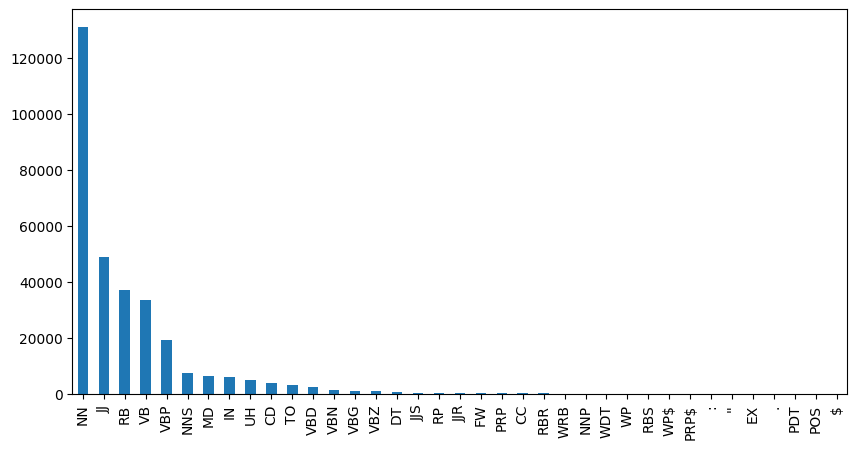

In [ ]:
new_d["POS"].value_counts().plot(kind="bar", figsize=(10,5))
#top POS tags

<Axes: >

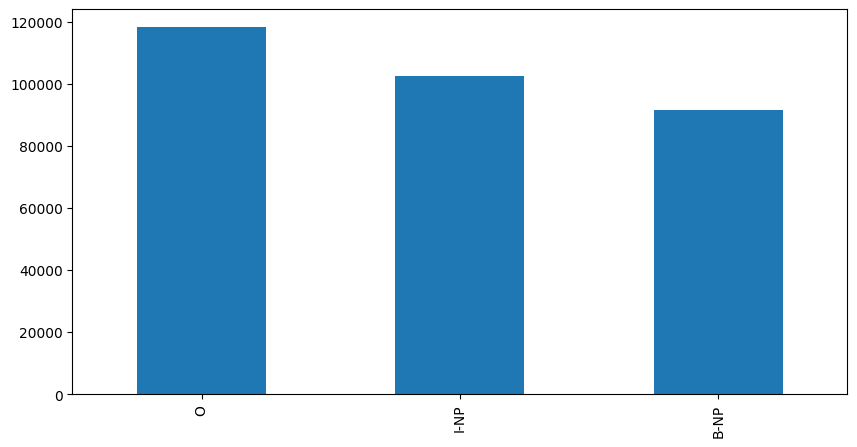

In [ ]:
new_d[new_d["Tag"]!="o"]["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

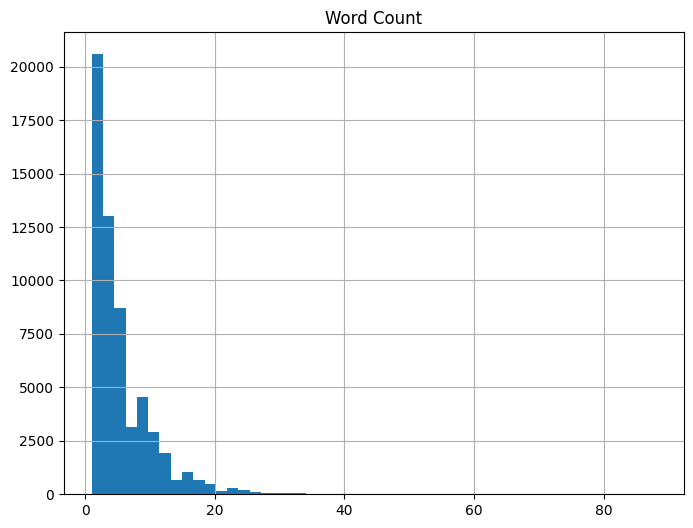

In [ ]:
#distb of words per sentence
word_counts = new_d.groupby("Sentence")["Token"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word Count"})
word_counts.hist(bins=50, figsize=(8,6));

In [ ]:
#unique words and tags
all_words = list(set(new_d["Token"].values))
all_tags = list(set(new_d["Tag"].values))

print("Number of unique words: {}".format(new_d["Token"].nunique()))
print("Number of unique tags : {}".format(new_d["Tag"].nunique()))

Number of unique words: 12858
Number of unique tags : 3


In [ ]:
#Longest sentence length and ID
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

longest_sentence_id = word_counts[word_counts["Word Count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))

Longest sentence in the corpus contains 88 words.
ID of the longest sentence is 53427.


##Creating Dictionaries

In [ ]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}

word2index["--UNKNOWN_WORD--"]=0

word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

#Visualising first 10 entries, including Unk and Padding entires

for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[:10]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
sr 2
comedy 3
risotto 4
alvin 5
woolery 6
fume 7
uhhhhhh 8
valium 9


In [ ]:
#testing the mapping
test_word = "ross"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word ross is 5925.
The word with index 5925 is ross.


In [ ]:
#dictionary for tags
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

for n,m in sorted(tag2index.items()):
    print(n,m)

--PADDING-- 0
B-NP 3
I-NP 1
O 2


In [ ]:
#Function to form tuple of token, pos and tag
def to_tuples(data):
    iterator = zip(data["Token"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = new_d.groupby("Sentence").apply(to_tuples).tolist()

#Example sentence
print(sentences[0])

[('nothing', 'NN', 'B-NP'), ('tell', 'NN', 'I-NP'), ('guy', 'NN', 'I-NP'), ('work', 'NN', 'I-NP')]


In [ ]:
#extracting features(X) and labels(y)
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

#Transforming into indicies format
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])


X[0]: ['nothing', 'tell', 'guy', 'work']
y[0]: ['B-NP', 'I-NP', 'I-NP', 'I-NP']
X[0]: [11339, 2616, 5757, 3910]
y[0]: [3, 1, 1, 1]


In [ ]:
#Padding to fix length of inputs

X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [11339, 2616, 5757, 3910, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
#one-hot encoding labels
TAG_COUNT = len(tag2index)
y = [np.eye(TAG_COUNT)[sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [11339, 2616, 5757, 3910, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 

##Splitting Data into Training and Test


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset : {}".format(len(X_test)))

Number of sentences in the training dataset: 41104
Number of sentences in the test dataset : 17616


In [ ]:
#converting to arrays for simplicity
X_train= np.array(X_train)
X_test= np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

##Building Model

###Installing packages

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-y8z6ppn8
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-y8z6ppn8
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install --exists-action i --upgrade keras-rl2 --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.5 MB/s eta 0:00:00


#Defining Architecture


In [ ]:
#Defining hyperparamters

WORD_COUNT=len(index2word)
DENSE_EMBEDDING = 100 # Dimension of dense embedding
LSTM_UNITS = 100 # dimension of the LSTM ouput space
LSTM_DROPOUT = 0.1 #Fraction of LSTM units to drop for linear transf
DENSE_UNITS = 150 # No. fully connected units per temporal slice
BATCH_SIZE=250 # No. samples in traing batch
MAX_EPOCHS=5 # Max No. trainging epochs

In [ ]:
#Defining architecture

input_layer = layers.Input(shape=(MAX_SENTENCE,))

model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)
#transform indices into dense vectors
model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)
#to apply dence output layer to each temporal slice

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss #negative log-likelihood
acc_metric = metrics.crf_accuracy #monitoring metric
opt = optimizers.Adam(lr=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 88)]              0         
                                                                 
 embedding (Embedding)       (None, 88, 50)            643000    
                                                                 
 bidirectional (Bidirectiona  (None, 88, 100)          40400     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 88, 100)          10100     
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 88, 4)             428       
                                                                 
Total params: 693,928
Trainable params: 693,928
Non-trainable

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.3, verbose=2)

Epoch 1/5


AttributeError: ignored

In [ ]:
plot_history(history.history)

In [ ]:
#testing model against a hold out set
y_pred= ner_model.predict(X_test)

y_pred= np.argmax(y_pred, axis=2)

y_test= np.argmax(y_test, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}/".format(accuracy))

551/551 [==============================] - 28s 51ms/step
Accuracy: 0.0200/
